In [1]:
import arviz as az
import numpyro
from numpyro.infer import Predictive, log_likelihood
import jax
import jax.random as random
import jax.numpy as jnp
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from tqdm.notebook import tqdm

# Add ../code to PYTHON_PATH
sys.path.insert(0, "../code")
import bnns.model_configs
from bnns.rasmus_bnn import LATENT
from datasets.synthetic import SyntheticDataset
from datasets.uci import UCIDataset, dataset_names, load_standard_splits
from utils import normalize, check_test_normed

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Adjust as needed
#SAMPLE_PATH = "../samples/2025-03-11T11:57:19.838834" # Golden standar (Ola)
SAMPLE_PATH = "../samples/2025-05-27T15:58:47.081632" # My version
#SAMPLE_PATH = SAMPLE_PATH + "/HMC"
SEED = 10

In [4]:
# Load samples
def load_samples():
    methods = os.listdir(SAMPLE_PATH)
    methods = [method for method in methods if os.path.isdir(os.path.join(SAMPLE_PATH, method))]
    samples = []
    for method in methods:
        datasets_in_dir = os.listdir(os.path.join(SAMPLE_PATH, method))
        for dataset_name in datasets_in_dir:
            path = os.path.join(SAMPLE_PATH, method, dataset_name)
            if method == "SVI":
                splits = os.listdir(path)
                for split in splits:
                    with open(os.path.join(path, split), "rb") as f:
                        svi_result = dill.load(f)
                    model_name = "_".join(split.split(".")[0].split("_")[:-1])
                    split_ind = split.split(".")[0].split("_")[-1]
                    model = getattr(bnns.model_configs, model_name)
                    params = svi_result["params"]
                    guide = svi_result["guide"]
                    predictive = Predictive(guide, params=params, num_samples=1)
                    post_draws = predictive(jax.random.PRNGKey(SEED), None)
                    samples.append({
                        "dataset": dataset_name,
                        "model": model,
                        "method": method,
                        "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                        "model": model_name,
                        "split": split_ind,
                        "post_draws": post_draws
                    })
            if method == "HMC":
                splits = os.listdir(path)
                for split in splits:
                    if ".nc" not in split:
                        continue
                    inference_data = az.from_netcdf(os.path.join(path, split))
                    model_name = "_".join(split.split(".")[0].split("_")[:-1])
                    split_ind = split.split(".")[0].split("_")[-1]
                    model = getattr(bnns.model_configs, model_name)

                    post_draws = inference_data.to_dict()["posterior"]
                    post_draws.pop("y_probs", None)

                    with open(os.path.join(path, split.replace(".nc", "_metadata.dill")), "rb") as f:
                        metadata = dill.load(f)
                    samples.append({
                        "dataset": dataset_name,
                        "model": model,
                        "method": method,
                        "method_name": "MAP" if method == "SVI" else "NUTS" if method == "HMC" else method,
                        "model": model_name,
                        "split": split_ind,
                        "post_draws": post_draws,
                        "inference_data": inference_data,
                        "time_spanned": metadata["time_spanned"],
                        "accept_prob": metadata["accept_prob"],
                    })
    return samples
samples = load_samples()

In [5]:
def get_dataset(dataset_name, split_ind):
    # Load dataset
    dataset = UCIDataset(dataset_name)
    X, y = dataset.X, dataset.y
    split = dataset.splits[split_ind]
    X_train, y_train = X[split["tr"]], y[split["tr"]]
    X_train, X_mean, X_std = normalize(X_train, None, None)
    X_test, y_test = X[split["te"]], y[split["te"]]
    X_test, _, _ = normalize(X_test, X_mean, X_std)
    check_test_normed(X_test)
    return X_train, y_train, X_test, y_test

# Compute Negative-Log-Likelihood, RMSE
To compare with Stein paper, Table 2

In [6]:
table_df = []
preds = []
for sample_dict in tqdm(samples):
    dataset_name = sample_dict["dataset"]
    model_name = sample_dict["model"]
    split_ind = sample_dict["split"]
    post_draws = sample_dict["post_draws"].copy()
    method = sample_dict["method"]

    # Get latent variable keys
    latent = list(post_draws.keys())

    if method == "HMC":
        batch_ndims = 2
    else:
        batch_ndims = 1

    post_draws_no_chain = {} 
    for key in post_draws:
        assert post_draws[key].shape[0] == 1
        post_draws_no_chain[key] = post_draws[key][0]

    # Load dataset
    X_train, y_train, X_test, y_test = get_dataset(dataset_name, int(split_ind))

    # Load model
    model = getattr(bnns.model_configs, model_name)

    # Remove "y_loc" from posterior samples
    post_draws.pop("y_loc", None)

    # Compute NLL
    train_nll = log_likelihood(model, post_draws, X=X_train, y=y_train, batch_ndims=batch_ndims)["y"]
    train_nll = jax.scipy.special.logsumexp(train_nll, axis=-2) - jnp.log(train_nll.shape[-2]) # Estimate log-posterior-predictive
    train_nll_mean = -train_nll.mean()
    train_nll_std = train_nll.std()

    nll_posterior = Predictive(model, post_draws, return_sites=latent, batch_ndims=batch_ndims)
    nll_posterior_draws = nll_posterior(jax.random.PRNGKey(42), X=X_test, y=None, D_Y=1)
    test_nll = log_likelihood(model, nll_posterior_draws, X=X_test, y=y_test, batch_ndims=batch_ndims)["y"]
    test_nll = jax.scipy.special.logsumexp(test_nll, axis=-2) - jnp.log(test_nll.shape[-2]) # Estimate log-posterior-predictive
    test_nll_mean = -test_nll.mean()
    test_nll_mean_std = test_nll.std()

    # Compute RMSE
    predictive = Predictive(model, post_draws, return_sites=["y_loc"], batch_ndims=batch_ndims)
    predictions_train = predictive(jax.random.PRNGKey(SEED), X_train, D_Y=1)["y_loc"]
    predictions_test = predictive(jax.random.PRNGKey(SEED), X_test, D_Y=1)["y_loc"]

    rmse_train = jnp.sqrt(jnp.mean((predictions_train - y_train) ** 2, axis=-1))
    rmse_train_mean = rmse_train.mean()
    rmse_train_std = rmse_train.std()

    rmse_test = jnp.sqrt(jnp.mean((predictions_test - y_test) ** 2, axis=-1))
    rmse_test_mean = rmse_test.mean()
    rmse_test_std = rmse_test.std()

    if method == "HMC":
        if "Spectral" in sample_dict["model"]:
            for i in range(len([key in post_draws for key in post_draws.keys() if "w_hat" in key])):
                post_draws.pop(f"w_hat_{i}", None)
        summary = numpyro.diagnostics.summary(post_draws)

        ess = np.array([value["n_eff"].mean() for _, value in summary.items()]).mean()
        rhat = np.array([value["r_hat"].mean() for _, value in summary.items()]).mean()
        time_spanned = sample_dict.get("time_spanned", None)
        accept_prob = sample_dict.get("accept_prob", None)
        ess_per_s = ess / time_spanned
    else:
        ess = np.nan
        rhat = np.nan
        time_spanned = np.nan
        accept_prob = np.nan
        ess_per_s = np.nan

    table_df.append({
        "method": method,
        "dataset": dataset_name,
        "model": model_name,
        "split": split_ind,
        "train_nll_mean": train_nll_mean,
        "train_nll_std": train_nll_std,
        "test_nll_mean": test_nll_mean,
        "test_nll_std": test_nll_mean_std,
        "rmse_train_mean": rmse_train_mean,
        "rmse_train_std": rmse_train_std,
        "rmse_test_mean": rmse_test_mean,
        "rmse_test_std": rmse_test_std,
        "ess": ess,
        "rhat": rhat,
        "time_spanned": time_spanned,
        "accept_prob": accept_prob.mean() if not np.any(np.isnan(accept_prob)) else np.nan,
        "ess_per_s": ess_per_s

    })

    preds.append({
        "dataset": dataset_name,
        "model": model_name,
        "split": split_ind,
        "predictions_train": predictions_train,
        "predictions_test": predictions_test,
        "y_train": y_train,
        "y_test": y_test
    })
table_df = pd.DataFrame(table_df)
table_df


  0%|          | 0/5 [00:00<?, ?it/s]

,method,dataset,model,split,train_nll_mean,train_nll_std,test_nll_mean,test_nll_std,rmse_train_mean,rmse_train_std,rmse_test_mean,rmse_test_std,ess,rhat,time_spanned,accept_prob,ess_per_s
0,HMC,power-plant,UCI_Full_Spectral_BNN_50,1,2.8619552,1.4333799,4530484.5,30743678.0,778751.1,521585.94,770314.8,509393.34,11.497115,1.341152,3175.107640,0.9163808,0.003621
1,HMC,power-plant,UCI_Full_Spectral_BNN_50,0,2.8496234,1.3031063,304267.9,1653261.4,743523.4,370926.6,754111.56,369201.12,10.520068,1.367648,3155.156987,0.9486503,0.003334
2,HMC,power-plant,UCI_Full_Spectral_BNN_50,4,2.7816308,1.4057173,19079330000.0,67019100000.0,4212205.5,1207391.8,4340156.0,1227888.9,7.709445,1.525813,3049.335258,0.92111343,0.002528
3,HMC,power-plant,UCI_Full_Spectral_BNN_50,3,2.7909198,1.236813,61319396.0,249914850.0,3514938.0,1576818.4,3488835.5,1551775.0,7.671411,1.566404,3036.237691,0.7849045,0.002527
4,HMC,power-plant,UCI_Full_Spectral_BNN_50,2,2.821737,1.2660285,418279800.0,2062927000.0,2814666.0,1202522.0,2772708.8,1200638.8,7.259710,1.486401,3131.049545,0.9480148,0.002319


In [20]:
#table_df[["test_nll_mean", "rmse_test_mean", "ess", "rhat", "time_spanned", "accept_prob", "ess_per_s"]].astype(np.float32).mean()
mean_row = table_df[["test_nll_mean", "rmse_test_mean", "ess", "rhat", "time_spanned", "accept_prob", "ess_per_s"]].astype(np.float32).std()
print(mean_row.to_frame().T)

   test_nll_mean  rmse_test_mean       ess      rhat  time_spanned  \
0   8.480144e+09     1616347.875  1.935333  0.098707     62.929302   

   accept_prob  ess_per_s  
0     0.068119   0.000574  


In [8]:
table = [{"dataset": x["dataset"], "model": x["model"], "split": x["split"]} for x in models]
for row, d in zip(models, table):
    dataset = UCIDataset(d["dataset"])
    splits = load_standard_splits(True)[d["dataset"]]
    samples = row["samples"].copy()

    # Important: Squeeze out the redundant chain dimension
    for key in samples:
        assert samples[key].shape[0] == 1
        samples[key] = samples[key][0]

    model = bnns.model_configs.__dict__[row["model"]]
    train_split = splits[d["split"]]["tr"]
    test_split = splits[d["split"]]["te"]

    #X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    X = dataset.X
    train_X, mean_X, std_X = normalize(X[train_split], None, None)

    assert train_X.mean().item() < 1e-5
    assert train_X.std().item() - 1.0 < 1e-5
    train_y = dataset.y[train_split]
    test_X, _, _ = normalize(X[test_split], mean_X, std_X)
    test_y = dataset.y[test_split]
    check_test_normed(train_X)

    # train_X = X[train_split]
    # train_y = y[train_split]
    # test_X = X[test_split]
    # test_y = y[test_split]

    train_nll = -log_likelihood(model, samples, X=train_X, y=train_y.flatten(), batch_ndims=1)["y"]
    # print(test_X.shape, test_y.shape)
    test_nll = -log_likelihood(model, samples, X=test_X, y=test_y.flatten(), batch_ndims=1)["y"]

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=1)
    # print(samples.keys())
    predicted_ys = predictive(model_key, X=train_X, y=None, D_Y=1)["y_loc"]
    train_rmse = jnp.sqrt(((train_y - predicted_ys[0])**2).mean())

    predictive = Predictive(model, posterior_samples=samples, return_sites=["y_loc"], batch_ndims=1)
    predicted_ys = predictive(model_key, X=test_X, y=None, D_Y=1)["y_loc"]
    test_rmse = jnp.sqrt(((test_y - predicted_ys[0])**2).mean())

    #d["train_nll"] = train_nll.mean()
    LATENT = list(row["samples"].keys())
    nll_post_samples = Predictive(model, posterior_samples=samples, return_sites=LATENT, batch_ndims=1)(random.PRNGKey(42), X=train_X, y=None, D_Y=1)
    assert jnp.allclose(nll_post_samples["b0"][:5], samples["b0"][:5])
    d["train_nll"] = nll_reg_fn(nll_post_samples, model, train_X, train_y, 1)
    nll_post_samples = Predictive(model, posterior_samples=samples, return_sites=LATENT, batch_ndims=1)(random.PRNGKey(42), X=test_X, y=None, D_Y=1)
    d["test_nll"] = nll_reg_fn(nll_post_samples, model, test_X, test_y, 1)
    d["train_rmse"] = train_rmse.item()
    d["test_rmse"] = test_rmse.item()
table_df = pd.DataFrame(table)
table_df

NameError: name 'models' is not defined

In [7]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test and prepare the table
results_table = []
def bold_if_significant(value, significant):
    return f"$\\underlined{{{value}}}$" if significant else f"${value}$"
    #return value
for dataset in table_df["dataset"].unique():
    splits = table_df.loc[table_df["dataset"] == dataset, "split"].unique()
    for model in table_df["model"].unique():
        for method in ["HMC", "SVI"]:
            baseline = table_df.loc[(table_df["dataset"] == dataset) & (table_df["model"] == "UCI_BNN_50") & (table_df["method"] == method)]
            comparison = table_df.loc[(table_df["dataset"] == dataset) & (table_df["model"] == model) & (table_df["method"] == method)]

            if len(baseline) == 0 or len(comparison) == 0:
                continue

            # Extract values
            nll_baseline = baseline["test_nll_mean"].astype(float)
            nll_comparison = comparison["test_nll_mean"].astype(float)
            rmse_baseline = baseline["rmse_test_mean"].astype(float)
            rmse_comparison = comparison["rmse_test_mean"].astype(float)
            ess_baseline = baseline["ess"]
            ess_comparison = comparison["ess"]
            rhat_baseline = baseline["rhat"]
            rhat_comparison = comparison["rhat"]
            ess_s_baseline = baseline["ess_per_s"]
            ess_s_comparison = comparison["ess_per_s"]

            # Perform Mann-Whitney U test
            nll_stat, nll_p = mannwhitneyu(nll_baseline, nll_comparison, alternative="greater")
            rmse_stat, rmse_p = mannwhitneyu(rmse_baseline, rmse_comparison, alternative="greater")
            ess_stat, ess_p = mannwhitneyu(ess_baseline, ess_comparison, alternative="less")
            rhat_stat, rhat_p = mannwhitneyu(rhat_baseline, rhat_comparison, alternative="greater")
            ess_s_stat, ess_s_p = mannwhitneyu(ess_s_baseline, ess_s_comparison, alternative="less")

            # Significance
            nll_significant = nll_p < 0.05
            rmse_significant = rmse_p < 0.05
            ess_significant = ess_p < 0.05
            rhat_significant = rhat_p < 0.05
            ess_s_significant = ess_s_p < 0.05

            # Append results
            results_table.append({
                "model": model,
                "method": method,
                "dataset": dataset,
                "NLL": bold_if_significant(f"{nll_comparison.mean() : .3f}\\pm{nll_comparison.std() : .3f}", nll_significant),
                "RMSE": bold_if_significant(f"{rmse_comparison.mean() : .3f}\\pm{rmse_comparison.std() : .3f}", rmse_significant),
                "Time": f"{comparison['time_spanned'].mean() : .3f}",
                "Speedup": f"{baseline['time_spanned'].mean() / comparison['time_spanned'].mean() : .3f}",
                "Acceptance Prob": f"{comparison['accept_prob'].mean() : .3f}",
                "ESS": bold_if_significant(f"{comparison['ess'].mean() : .3f}\\pm{comparison['ess'].std() : .3f}", ess_significant),
                "R-hat": bold_if_significant(f"{comparison['rhat'].mean() : .3f}\\pm{comparison['rhat'].std() : .3f}", rhat_significant),
                "ESS/s": bold_if_significant(f"{comparison['ess_per_s'].mean() : .3f}\\pm{comparison['ess_per_s'].std() : .3f}", ess_s_significant),
            })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results_table)
dataset = "power-plant"
transposed = results_df.loc[(results_df["method"] == "HMC") & (results_df["dataset"] == dataset)].transpose()
transposed
#results_df["dataset"].unique()
#d.groupby(by=["model", "method", "width", "split"]).mean()

KeyError: 'method'

# Grouped stats
**Important:** Standard deviation is denoted as the variance between mean of splits

In [26]:
table_df["split"] = table_df["split"].astype(int)
grouped = table_df.groupby(["method", "dataset", "model"]).mean()
stds = table_df.groupby(["method", "dataset", "model"]).std()
d = pd.DataFrame(columns=["Method", "Dataset", "Model", "NLL (train)", "NLL (test)", "RMSE (train)", "RMSE (test)"])
for i, row in enumerate(grouped.iterrows()):
    method, dataset, model = row[0]
    train_nll = f"{float(row[1]['train_nll_mean']):.3f}±{float(stds.iloc[i]['train_nll_mean']):.3f}"
    test_nll = f"{float(row[1]['test_nll_mean']):.3f}±{float(stds.iloc[i]['test_nll_mean']):.3f}"
    train_rmse = f"{float(row[1]['rmse_train_mean']):.3f}±{float(stds.iloc[i]['rmse_train_mean']):.3f}"
    test_rmse = f"{float(row[1]['rmse_test_mean']):.3f}±{float(stds.iloc[i]['rmse_test_mean']):.3f}"
    d.loc[i] = [method, dataset, model, train_nll, test_nll, train_rmse, test_rmse]
d
#grouped["target_test_nll"] = ["2.2±0.2", "2.2±0.2","2.7±0.3", "2.7±0.3", "0.5±1.5", "0.5±1.5"]
#grouped["target_test_rmse"] = ["3.6±0.7","3.6±0.7", "4.7±0.6","4.7±0.6", "0.3±0.1", "0.3±0.1"]

,Method,Dataset,Model,NLL (train),NLL (test),RMSE (train),RMSE (test)
0,SVI,power-plant,UCI_Full_Spectral_BNN_50,3.269±nan,3.305±nan,6.040±nan,6.385±nan


# Hypothesis test
Two hypothesis, three metrics (ESS/s, NLL, RMSE):
1) CBNN and BNN provide an identical distribution of (metric)
2) Spectral CBNN and BNN provide an identical distribution of (metric)

# ArviZ posterior predictive check

In [11]:
key = jax.random.PRNGKey(SEED)
keys = jax.random.split(key, (len(models), 2))
fig, axs = plt.subplots(len(models), 2, figsize=(15, 5*len(models)))
axs = np.array([axs]) if len(models) == 1 else axs
for (key_tr, key_te), d, row in zip(keys, models, range(len(models))):
    model = bnns.model_configs.__dict__[d["model"]]
    predictive = Predictive(model, posterior_samples=d["samples"], return_sites=["y"], batch_ndims=2, parallel=True)
    dataset = UCIDataset(d["dataset"])
    split = load_standard_splits(True)[d["dataset"]][d["split"]]

    X = dataset.normalize_X(dataset.data[:, :-1], splits[d["split"]])
    y = dataset.data[:, -1]

    train_X = X[split["tr"]]
    train_y = y[split["tr"]]
    test_X = X[split["te"]]
    test_y = y[split["te"]]
    predictive_ys = predictive(key_tr, X=train_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": train_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": train_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 0], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,0].set_title("Train")

    predictive_ys = predictive(key_te, X=test_X, y=None, D_Y=1)["y"]
    az_data = az.from_dict(posterior_samples=d["az_data"].posterior, constant_data={"X": test_X}, posterior_predictive={"y": predictive_ys}, observed_data={"y": test_y})
    az.plot_ppc(az_data, data_pairs={"y": "y"}, ax=axs[row, 1], kind="kde", observed_rug=True, alpha=0.1)
    axs[row,1].set_title("Test")
    

NameError: name 'models' is not defined

# Plot similar to NumPyro SteinVI example

/tmp/ipykernel_10364/4270386506.py:60: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(predictions_train.mean(axis=0), "ko", label="Pred y (train)", color="blue", markersize=3)
/tmp/ipykernel_10364/4270386506.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(predictions_test.mean(axis=0), "ko", label="Pred y (test)", color="orange", markersize=3)


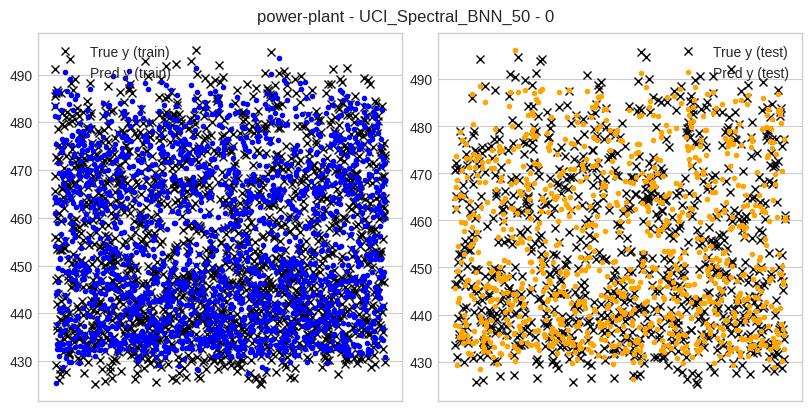

In [12]:
from matplotlib.collections import LineCollection
#fig, axs = plt.subplots(1, len(models), figsize=(8, 6*len(models)), constrained_layout=True)
#axs = axs.ravel()
SAMPLE_TO_PLOT = -1
sample_dict = samples[SAMPLE_TO_PLOT]
dataset_name = sample_dict["dataset"]
model_name = sample_dict["model"]
split_ind = sample_dict["split"]
post_draws = sample_dict["post_draws"]
method = sample_dict["method"]
batch_ndims = 2 if method == "HMC" else 1
key = jax.random.PRNGKey(SEED)

dataset_name, split_ind = sample_dict["dataset"], sample_dict["split"]

# Load dataset
X_train, y_train, X_test, y_test = get_dataset(dataset_name, int(split_ind))
X_train = X_train[::4] # only plot every 4th point
y_train = y_train[::4] # only plot every 4th point

# Load model
model = getattr(bnns.model_configs, model_name)

# Remove "y_loc" from posterior samples
post_draws.pop("y_loc", None)


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), constrained_layout=True)
fig.suptitle(f"{dataset_name} - {model_name} - {split_ind}")

predictive = Predictive(model, posterior_samples=post_draws, return_sites=["y", "y_loc"], batch_ndims=batch_ndims)
predictive = Predictive(model, post_draws, return_sites=["y_loc"], batch_ndims=batch_ndims)
predictions_train = predictive(jax.random.PRNGKey(SEED), X_train, D_Y=1)["y_loc"]
predictions_test = predictive(jax.random.PRNGKey(SEED), X_test, D_Y=1)["y_loc"]

if method == "HMC":
    predictions_train = predictions_train.squeeze()
    predictions_test = predictions_test.squeeze()

percentiles_train = jnp.percentile(predictions_train, jnp.array([5, 95]), axis=0)
percentiles_test = jnp.percentile(predictions_test, jnp.array([5, 95]), axis=0)

#rmse = jnp.sqrt(jnp.mean((predictive_ys[0,:,:,0].mean(0) - test_y) ** 2))
#percentiles = np.percentile(predictive_ys[0,:,:,0], [5, 95], axis=0)

ran_train = np.arange(predictions_train.shape[1])
axs[0].add_collection(
    LineCollection(
        zip(zip(ran_train, percentiles_train[0]), zip(ran_train, percentiles_train[1])), colors="blue", alpha=0.5
    )
)
ran_test = np.arange(predictions_train.shape[1])
axs[1].add_collection(
    LineCollection(
        zip(zip(ran_test, percentiles_test[0]), zip(ran_test, percentiles_test[1])), colors="orange", alpha=0.5
    )
)
axs[0].plot(y_train, "kx", label="True y (train)")
axs[1].plot(y_test, "kx", label="True y (test)")
axs[0].plot(predictions_train.mean(axis=0), "ko", label="Pred y (train)", color="blue", markersize=3)
axs[1].plot(predictions_test.mean(axis=0), "ko", label="Pred y (test)", color="orange", markersize=3)
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[0].legend()
axs[1].legend()


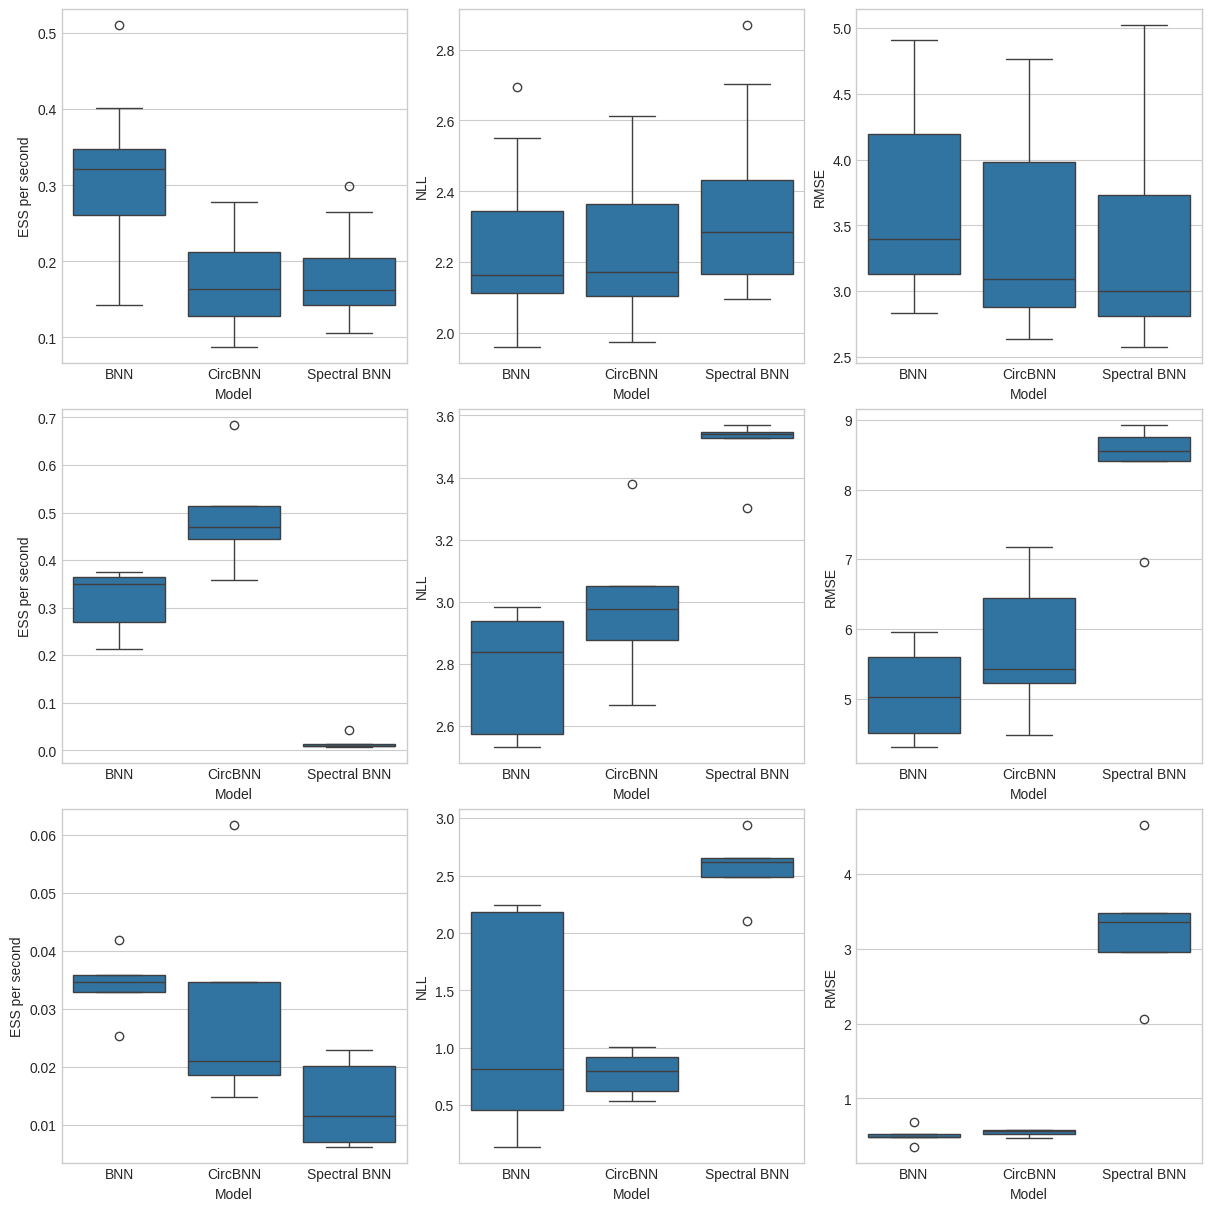

In [14]:

d = pd.DataFrame(columns=["Method", "Dataset", "Model", "# RVs", "Time spanned", "Sample throughput", "ESS", "ESS per second", "R-hat", "NLL", "RMSE"])
X_labels = {
    "UCI_BNN_50": "BNN",
    "UCI_Full_FFT_CBNN_50": "CircBNN",
    "UCI_Full_Spectral_BNN_50": "Spectral BNN",
}
for idx, sample_dict in enumerate(samples):
    if sample_dict["method"] == "SVI":
        continue
    dataset_name = sample_dict["dataset"]
    model_name = sample_dict["model"]
    split_ind = sample_dict["split"]
    post_draws = sample_dict["post_draws"].copy()
    rvs = np.array([np.array(list(value.shape[batch_ndims:])).prod() for _, value in post_draws.items()]).sum()
    method = sample_dict["method"]
    time_spanned = sample_dict["time_spanned"]
    accept_prob = sample_dict["accept_prob"]

    for key in post_draws.copy():
        if "hat" in key:
            post_draws.pop(key, None)
    summary = numpyro.diagnostics.summary(post_draws, prob=0.95)
    ess = np.array([value["n_eff"].mean() for _, value in summary.items()]).mean()
    r_hat = np.array([value["r_hat"].mean() for _, value in summary.items()]).mean()

    nll = table_df.loc[idx, "test_nll_mean"]
    rmse = table_df.loc[idx, "rmse_test_mean"]


    d.loc[len(d)] = [method, dataset_name, X_labels[model_name], rvs, time_spanned, 3500 / time_spanned, ess, ess / time_spanned, r_hat, float(nll), float(rmse)]

distinct_datasets = d["Dataset"].unique()
fig, axs = plt.subplots(ncols=3, nrows=len(distinct_datasets), figsize=(12, 4*len(distinct_datasets)), constrained_layout=True)

for i, dataset in enumerate(distinct_datasets):
    data = d.loc[d["Dataset"] == dataset]
    sns.boxplot(data=data, x="Model", y="ESS per second", ax=axs[i, 0], order=["BNN", "CircBNN", "Spectral BNN"])
    sns.boxplot(data=data, x="Model", y="NLL", ax=axs[i, 1], order=["BNN", "CircBNN", "Spectral BNN"])
    sns.boxplot(data=data, x="Model", y="RMSE", ax=axs[i, 2], order=["BNN", "CircBNN", "Spectral BNN"])
# fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 4), constrained_layout=True)
# sns.scatterplot(data=d, x="Time spanned", y="ESS", hue="Model", ax=axs[0], legend=False)
# sns.scatterplot(data=d, x="ESS per second", y="NLL", hue="Model", ax=axs[1], legend=False)
# sns.scatterplot(data=d, x="ESS per second", y="RMSE", hue="Model", ax=axs[2], legend=False)
# handles, labels = axs[0].get_legend_handles_labels()

/tmp/ipykernel_9244/3787068846.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["Boston Housing", "Concrete", "Energy"])
/tmp/ipykernel_9244/3787068846.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["Boston Housing", "Concrete", "Energy"])


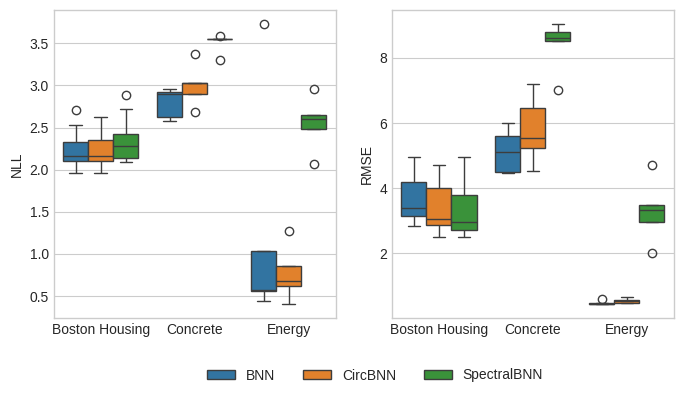

In [67]:
hmcs = table_df.loc[table_df["method"] == "HMC"].copy()
hmcs["test_nll_mean"] = hmcs["test_nll_mean"].astype(float)
hmcs["rmse_test_mean"] = hmcs["rmse_test_mean"].astype(float)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
sns.boxplot(data=hmcs, x="dataset", hue="model", y="test_nll_mean", ax=axs[0])
sns.boxplot(data=hmcs, x="dataset", hue="model", y="rmse_test_mean", ax=axs[1], legend=False)
handles, _ = axs[0].get_legend_handles_labels()
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[0].set_ylabel("NLL")
axs[1].set_ylabel("RMSE")
axs[0].set_xticklabels(["Boston Housing", "Concrete", "Energy"])
axs[1].set_xticklabels(["Boston Housing", "Concrete", "Energy"])
sns.move_legend(axs[0], "lower left", bbox_to_anchor=(0.5, -0.25), ncol=3, title="", frameon=False, labels=["BNN", "CircBNN", "SpectralBNN"])

/tmp/ipykernel_9244/4091222871.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["Boston Housing", "Concrete", "Energy"])
/tmp/ipykernel_9244/4091222871.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["Boston Housing", "Concrete", "Energy"])


[Text(0, 0, 'Boston Housing'), Text(1, 0, 'Concrete'), Text(2, 0, 'Energy')]

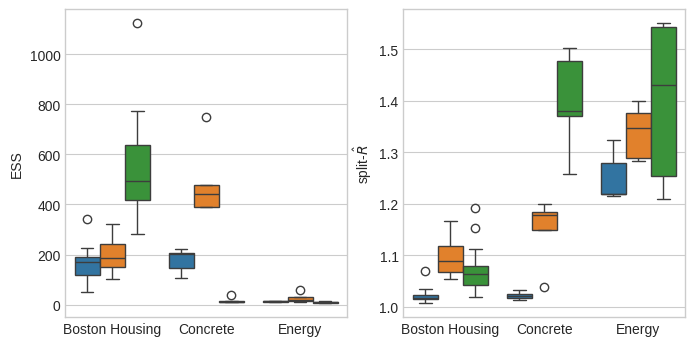

In [71]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
sns.boxplot(data=hmcs, x="dataset", hue="model", y="ess", ax=axs[0], legend=False)
sns.boxplot(data=hmcs, x="dataset", hue="model", y="rhat", ax=axs[1], legend=False)
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[0].set_ylabel("ESS")
axs[1].set_ylabel(r"split-$\hat{R}$")
axs[0].set_xticklabels(["Boston Housing", "Concrete", "Energy"])
axs[1].set_xticklabels(["Boston Housing", "Concrete", "Energy"])

In [ ]:
hmcs = table_df.loc[table_df["method"] == "HMC"].copy()
hmcs["test_nll_mean"] = hmcs["test_nll_mean"].astype(float)
hmcs["rmse_test_mean"] = hmcs["rmse_test_mean"].astype(float)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
sns.boxplot(data=hmcs, x="dataset", hue="model", y="test_nll_mean", ax=axs[0])
sns.boxplot(data=hmcs, x="dataset", hue="model", y="rmse_test_mean", ax=axs[1], legend=False)
handles, _ = axs[0].get_legend_handles_labels()
axs[0].set_xlabel("")
axs[1].set_xlabel("")
axs[0].set_ylabel("NLL")
axs[1].set_ylabel("RMSE")
axs[0].set_xticklabels(["Boston Housing", "Concrete", "Energy"])
axs[1].set_xticklabels(["Boston Housing", "Concrete", "Energy"])
sns.move_legend(axs[0], "lower left", bbox_to_anchor=(0.5, -0.25), ncol=3, title="", frameon=False, labels=["BNN", "CircBNN", "SpectralBNN"])

In [24]:
rhat_label = r"split-$\hat{R}$"
d = pd.DataFrame(columns=["model", "method", "dataset", "width", "split", "ESS", rhat_label, "Time (s)", "ESS/s"])
for sample in tqdm(samples):
    if sample["method"] == "SVI":
        continue
    post_draws = sample["post_draws"].copy()
    if "Spectral" in sample["model"]:
        for i in range(len([key in post_draws for key in post_draws.keys() if "w_hat" in key])):
            post_draws.pop(f"w_hat_{i}", None)
    summary = numpyro.diagnostics.summary(post_draws)
    w1 = summary["w1"] if "w1" in summary else summary["w_hat_0_normals"]
    ess = np.array([value["n_eff"].mean() for _, value in summary.items()]).mean()
    rhat = np.array([value["r_hat"].mean() for _, value in summary.items()]).mean()
    d.loc[len(d)] = [sample["model"], sample["method"], sample["dataset"], int(sample["model"].split("_")[-1]), int(sample["split"]), ess, rhat, sample["time_spanned"], ess / sample["time_spanned"]]

  0%|          | 0/197 [00:00<?, ?it/s]

In [25]:
d.groupby(["model", "method", "dataset"]).mean()

width  split         ESS  \
model                    method dataset                                    
UCI_BNN_50               HMC    boston-housing   50.0    9.5  332.374849   
                                concrete         50.0    2.0  312.318571   
                                energy           50.0    2.0   31.768519   
UCI_Full_FFT_CBNN_50     HMC    boston-housing   50.0    9.5  212.965285   
                                concrete         50.0    2.0  447.962282   
                                energy           50.0    2.0   29.363734   
UCI_Full_Spectral_BNN_50 HMC    boston-housing   50.0    9.0  511.325509   
                                concrete         50.0    2.0   17.232330   
                                energy           50.0    2.0   10.293361   

                                                split-$\hat{R}$     Time (s)  \
model                    method dataset                                        
UCI_BNN_50               HMC    boston-housing         1.018154  1067.935340   
                                concrete               1.018923   993.834621   
                                energy                 1.223117   936.589545   
UCI_Full_FFT_CBNN_50     HMC    boston-housing         1.083922  1252.590585   
                                concrete               1.135092   906.272819   
                                energy                 1.307137   972.653686   
UCI_Full_Spectral_BNN_50 HMC    boston-housing         1.069018  1677.480021   
                                concrete               1.383281  1409.652688   
                                energy                 1.384920   933.367508   

                                                   ESS/s  
model                    method dataset                   
UCI_BNN_50               HMC    boston-housing  0.311064  
                                concrete        0.314253  
                                energy          0.034080  
UCI_Full_FFT_CBNN_50     HMC    boston-housing  0.169795  
                                concrete        0.493735  
                                energy          0.030100  
UCI_Full_Spectral_BNN_50 HMC    boston-housing  0.304851  
                                concrete        0.011956  
                                energy          0.013773

In [20]:
samples[0]["post_draws"]["alpha1"]

Array([1.31942075e-08], dtype=float32)

In [35]:
jnp.sqrt(1/samples[0]["post_draws"]["prec"])

Array([1.3459997], dtype=float32)

# MCMC diagnostics

## Load metadata

In [11]:
from jax.numpy import float32, int32 , array as Array
import dill
metadatas = []
for dataset_name in os.listdir(SAMPLE_PATH):
    if not os.path.isdir(os.path.join(SAMPLE_PATH, dataset_name)):
        continue
    if dataset_name in dataset_names:
        for key, file_name in zip(model_keys, os.listdir(os.path.join(SAMPLE_PATH, dataset_name))):
            if file_name[-13:] == "metadata.dill":
                with open(os.path.join(SAMPLE_PATH, dataset_name, file_name), "rb") as f:
                    metadatas.append(dill.load(f))
metadatas

[{'accept_prob': Array([0.70137155, 0.8473585 , 0.6296817 , 0.8285232 , 0.52217454,
         0.4728051 , 0.9203443 , 0.9347981 , 0.8453467 , 0.9167628 ,
         0.66307276, 0.99957395, 0.96454936, 0.8794318 , 0.97177476,
         0.8498323 , 0.94290584, 0.5613212 , 0.95782226, 0.73588824,
         0.4502724 , 0.98605305, 0.9945368 , 0.89122164, 0.927898  ,
         0.98112166, 0.7047082 , 0.8931654 , 0.9042981 , 0.90679854,
         0.92203194, 0.9789038 , 0.9364866 , 0.80228245, 0.54777586,
         0.9496537 , 0.9604361 , 0.9231218 , 0.7594067 , 0.9978006 ,
         0.9981848 , 0.9686976 , 0.59600484, 0.9981059 , 0.7565586 ,
         0.9077806 , 0.8559679 , 0.9405323 , 0.8872966 , 0.9588449 ,
         0.9116816 , 0.9582425 , 0.92318225, 0.7000911 , 0.97630453,
         0.8865386 , 0.7572678 , 0.9467629 , 0.92078   , 0.6706086 ,
         0.95757484, 0.67371315, 0.8283383 , 1.        , 0.87685394,
         0.6303517 , 0.8845076 , 0.8168419 , 0.92428285, 0.90787536,
         0.84933865

# Acceptance probability

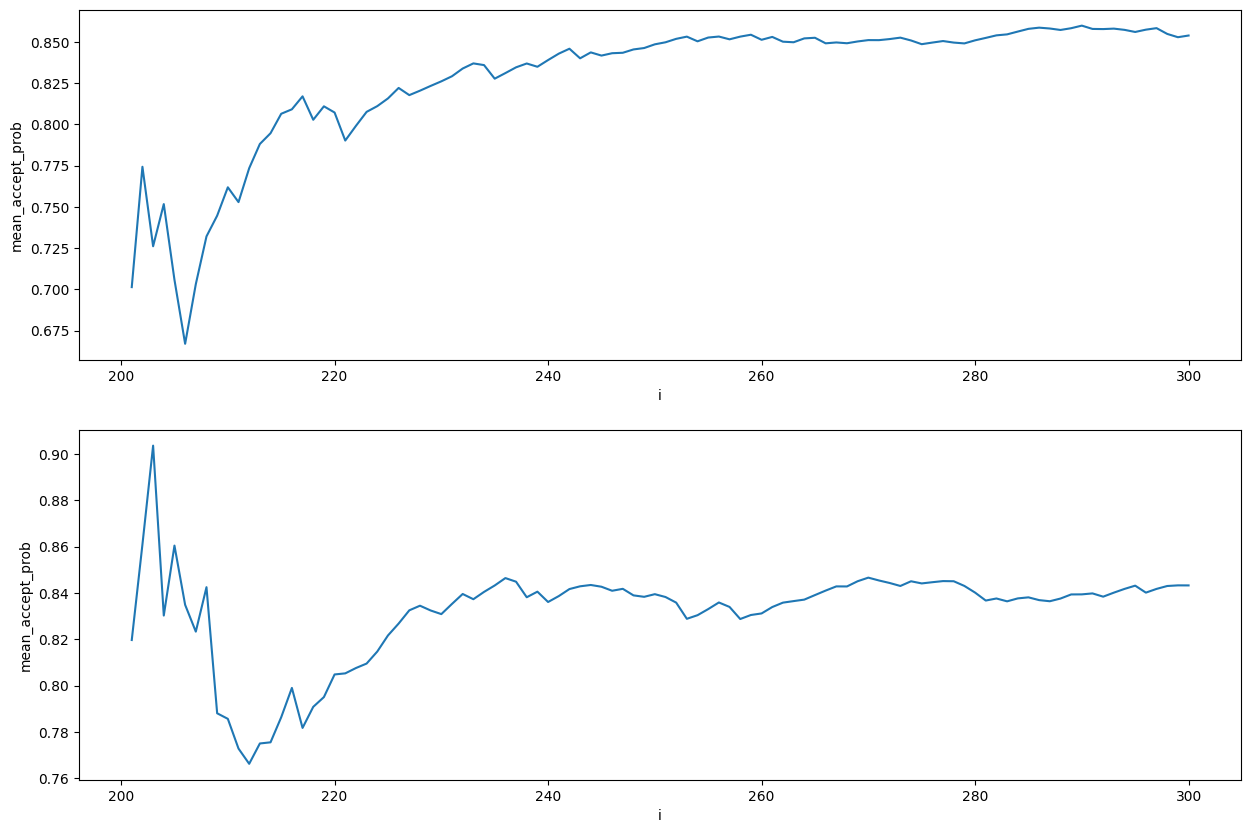

In [12]:
import seaborn as sns
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    sns.lineplot(data=data, x="i", y="mean_accept_prob", ax=ax)

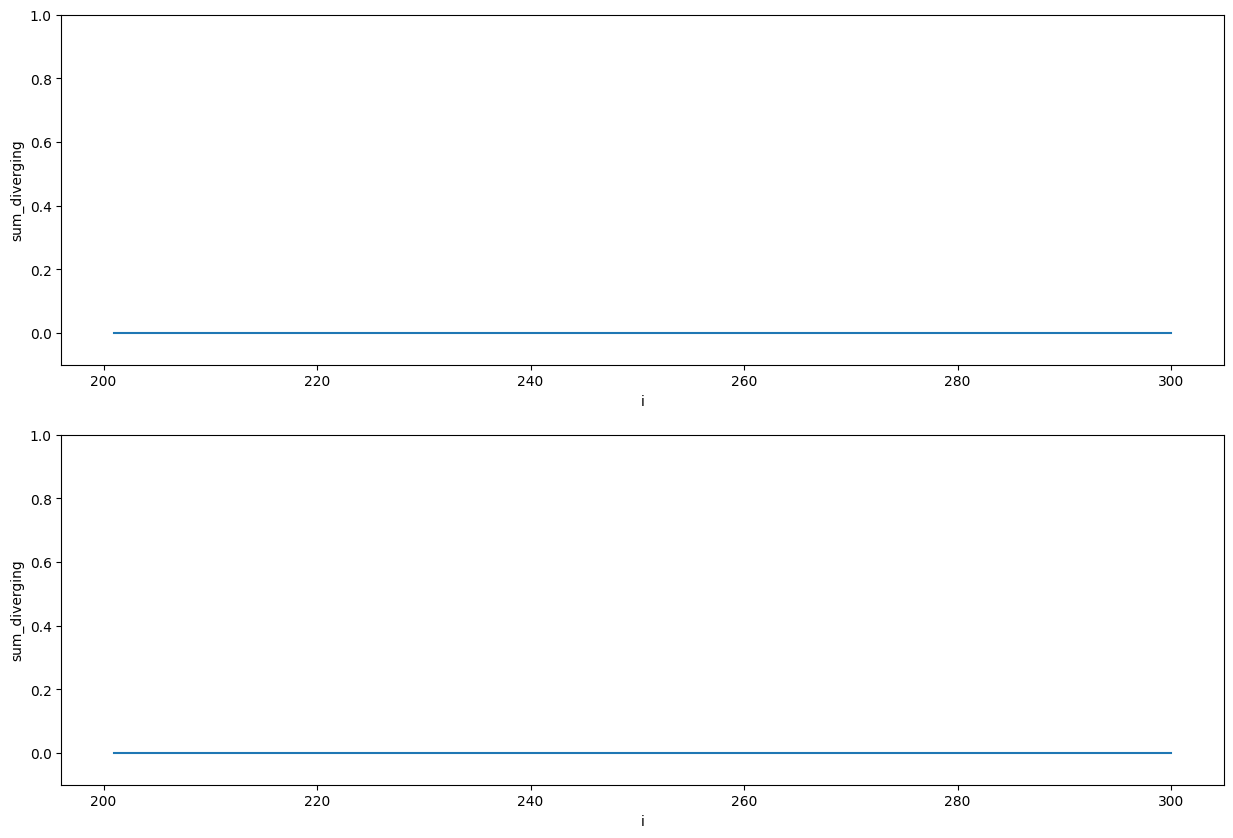

In [13]:
fig, axs = plt.subplots(len(metadatas), 1, figsize=(15, 5*len(metadatas)))
axs = np.array([axs]) if len(metadatas) == 1 else axs
for metadata, ax in zip(metadatas, axs):
    data = pd.DataFrame(metadata)
    data["sum_diverging"] = data["diverging"].cumsum()
    sns.lineplot(data=data, x="i", y="sum_diverging", ax=ax)
    ax.set_ylim([-0.1,1])

<Axes: xlabel='model_name', ylabel='time_spanned'>

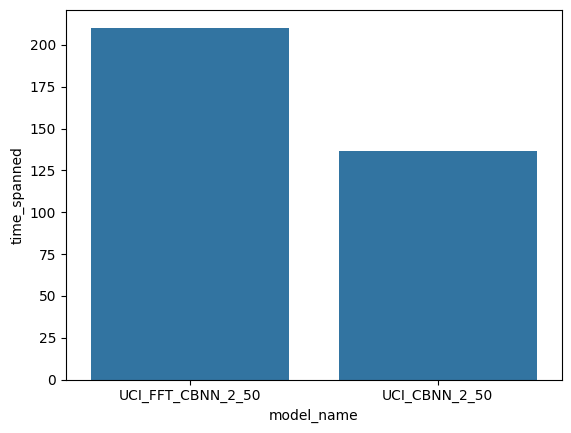

In [14]:
total_df = []
for i, metadata in enumerate(metadatas):
    metadata["model_name"] = models[i]["model"]
    total_df.append(metadata)
total_df = pd.DataFrame(total_df)
sns.barplot(data=total_df, x="model_name", y="time_spanned")

<Axes: xlabel='model', ylabel='prec'>

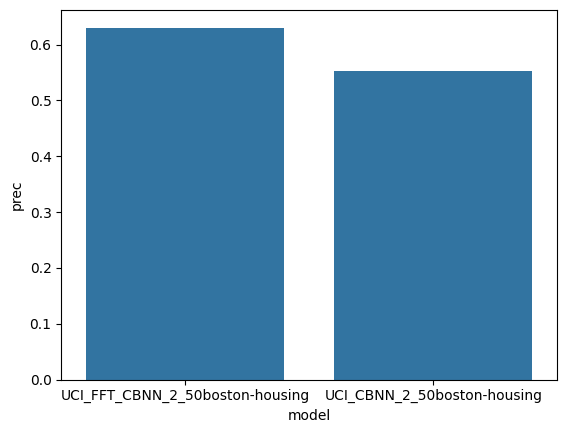

In [15]:
total_df = []
for model in models:
    total_df.append({"model": model["model"] + model["dataset"], "prec": model["samples"]["prec"].mean()})

sns.barplot(data=pd.DataFrame(total_df), x="model", y="prec")

In [15]:
jnp.sqrt(1/0.5)

Array(1.4142135, dtype=float32, weak_type=True)

# Precision prior vs posterior

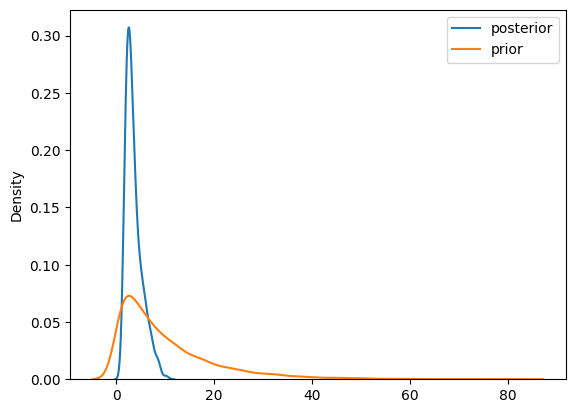

In [26]:
sns.kdeplot(data=d["samples"]["prec"].flatten(), label="posterior")
sns.kdeplot(jax.random.gamma(jax.random.PRNGKey(SEED), 1.0, (10000,))/0.1, label="prior")
plt.legend()

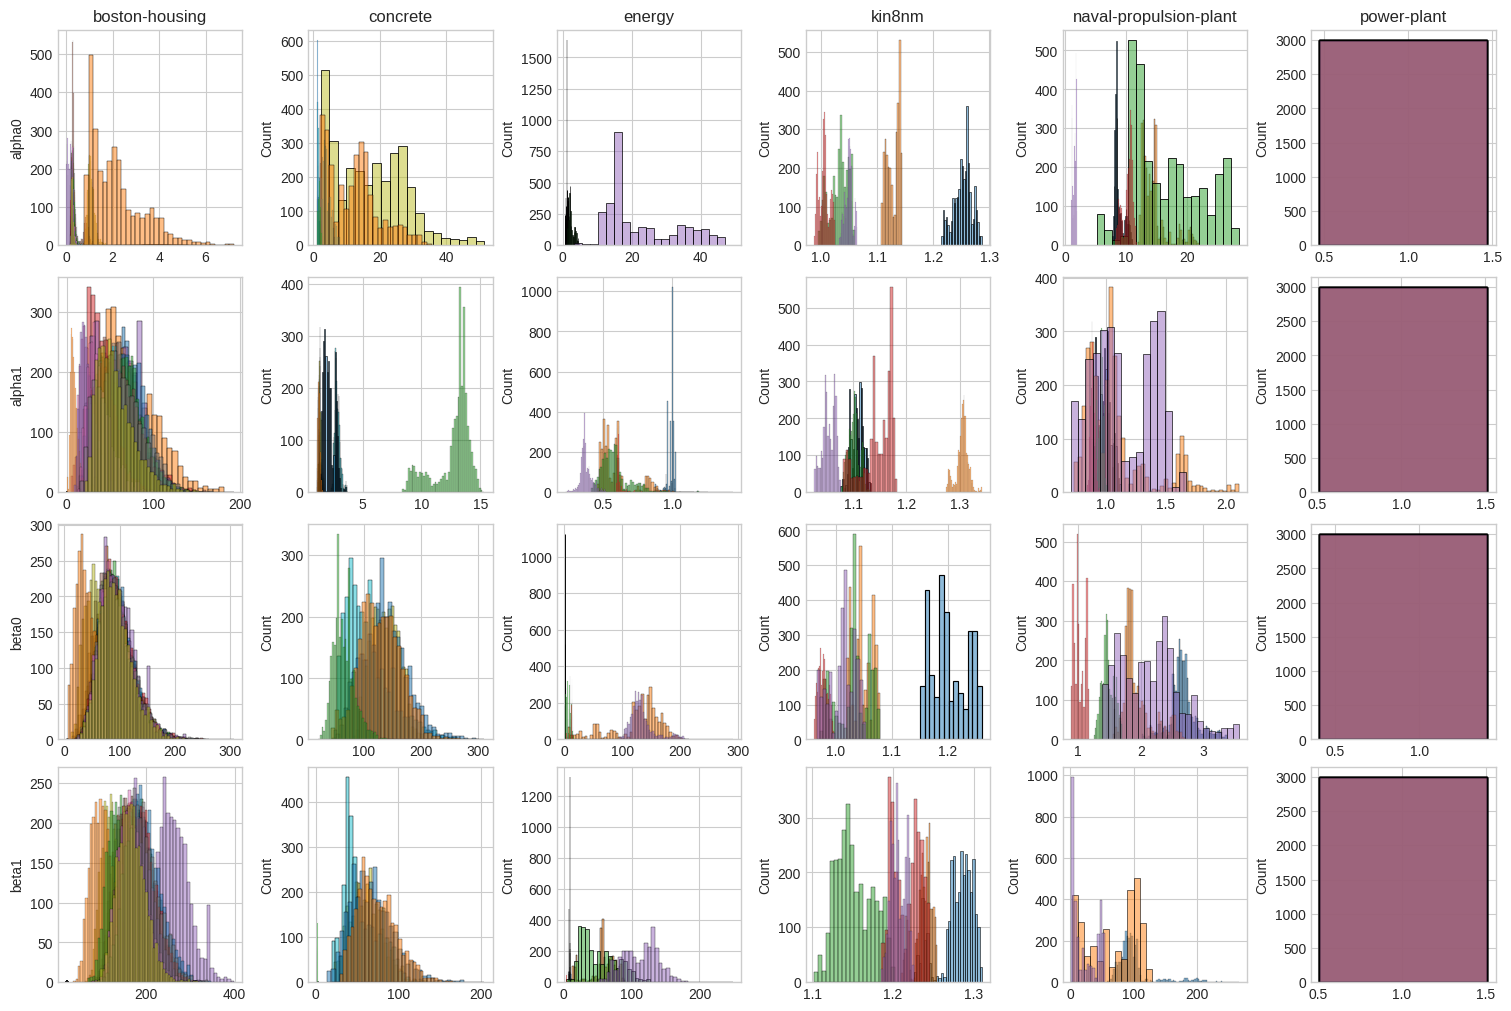

In [51]:
spectral_samples = [s for s in samples if "Spectral" in s["model"]]
fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(15, 10), constrained_layout=True)
hyperparams = ["alpha0", "alpha1", "beta0", "beta1"]
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        h = []
        for s in [s for s in spectral_samples if s["dataset"] == dataset_names[j]]:
            h.append(s["post_draws"][hyperparams[i]].flatten())
        for b in h:
            sns.histplot(data=b, ax=ax, alpha=0.5)
        if i == 0:
            ax.set_title(dataset_names[j])
        if j == 0:
            ax.set_ylabel(hyperparams[i])

In [35]:
spectral_samples

[{'dataset': 'power-plant',
  'model': 'UCI_Full_Spectral_BNN_50',
  'method': 'HMC',
  'method_name': 'NUTS',
  'split': '1',
  'post_draws': {'alpha0': array([[0.9709365, 0.9709365, 0.9709365, ..., 0.9709365, 0.9709365,
           0.9709365]], shape=(1, 3000), dtype=float32),
   'alpha1': array([[1.0110081, 1.0110081, 1.0110081, ..., 1.0110081, 1.0110081,
           1.0110081]], shape=(1, 3000), dtype=float32),
   'b0': array([[[ 0.00163256, -0.00804156, -0.00699626, ...,  0.02938621,
             0.04061693, -0.08361455],
           [ 0.00163256, -0.00804156, -0.00699626, ...,  0.02938621,
             0.04061693, -0.08361455],
           [ 0.00163256, -0.00804156, -0.00699626, ...,  0.02938621,
             0.04061693, -0.08361455],
           ...,
           [ 0.00163256, -0.00804156, -0.00699626, ...,  0.02938621,
             0.04061693, -0.08361455],
           [ 0.00163256, -0.00804156, -0.00699626, ...,  0.02938621,
             0.04061693, -0.08361455],
           [ 0.001632